In [1]:
options(warn=-1)
suppressMessages(library(tidyverse))
library(ggrepel)
suppressMessages(library(ggmap)) # has to be 2.70

In [2]:
setwd("~/Google Drive/PPUA5302 Info Design & Visual Analytics/My City in Time and Space")
data <- read.csv("crime.csv")
nrow(data) # 327820 records

[1] 327820

In [3]:
table(data$YEAR)

length(table(data$OFFENSE_CODE_GROUP)) # totally 67 types of incident

data <- data %>%
  filter(STREET != "") %>%
  mutate(SHOOTING = ifelse(SHOOTING == "Y", 1, 0))
# recode shooting

str(data)

table(data$SHOOTING) # 1031 shootings
table(data$YEAR) # investigate number of inceidents per year
table(data$HOUR) # investigate time pattern of incidents druing a day


  2015   2016   2017   2018 
 53392  99134 100938  74356 

[1] 67

'data.frame':	316843 obs. of  17 variables:
 $ INCIDENT_NUMBER    : Factor w/ 290156 levels "142052550","I010370257-00",..: 290156 290155 290154 290153 290152 290151 290149 290148 290147 290146 ...
 $ OFFENSE_CODE       : int  2403 3201 2647 413 3122 1402 3301 802 3410 3803 ...
 $ OFFENSE_CODE_GROUP : Factor w/ 67 levels "Aggravated Assault",..: 15 53 47 1 2 64 65 62 63 44 ...
 $ OFFENSE_DESCRIPTION: Factor w/ 244 levels "A&B HANDS, FEET, ETC.  - MED. ATTENTION REQ.",..: 63 187 222 13 5 231 232 21 223 162 ...
 $ DISTRICT           : Factor w/ 13 levels "","A1","A15",..: 12 9 5 2 4 7 5 12 10 9 ...
 $ REPORTING_AREA     : int  495 795 329 92 36 351 603 543 621 750 ...
 $ SHOOTING           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ OCCURRED_ON_DATE   : Factor w/ 239364 levels "2015-06-15 00:00:00",..: 239362 232564 239354 239361 239364 239180 239357 239355 239361 239358 ...
 $ YEAR               : int  2018 2018 2018 2018 2018 2018 2018 2018 2018 2018 ...
 $ MONTH              : int  10 8 10 10 1


     0      1 
315812   1031 


 2015  2016  2017  2018 
52110 93424 98207 73102 


    0     1     2     3     4     5     6     7     8     9    10    11    12 
15064  9027  7480  4520  3387  3289  5014  8807 13016 14756 16377 16439 18675 
   13    14    15    16    17    18    19    20    21    22    23 
16797 17077 16395 19677 20463 20109 17388 15805 13991 12783 10507 

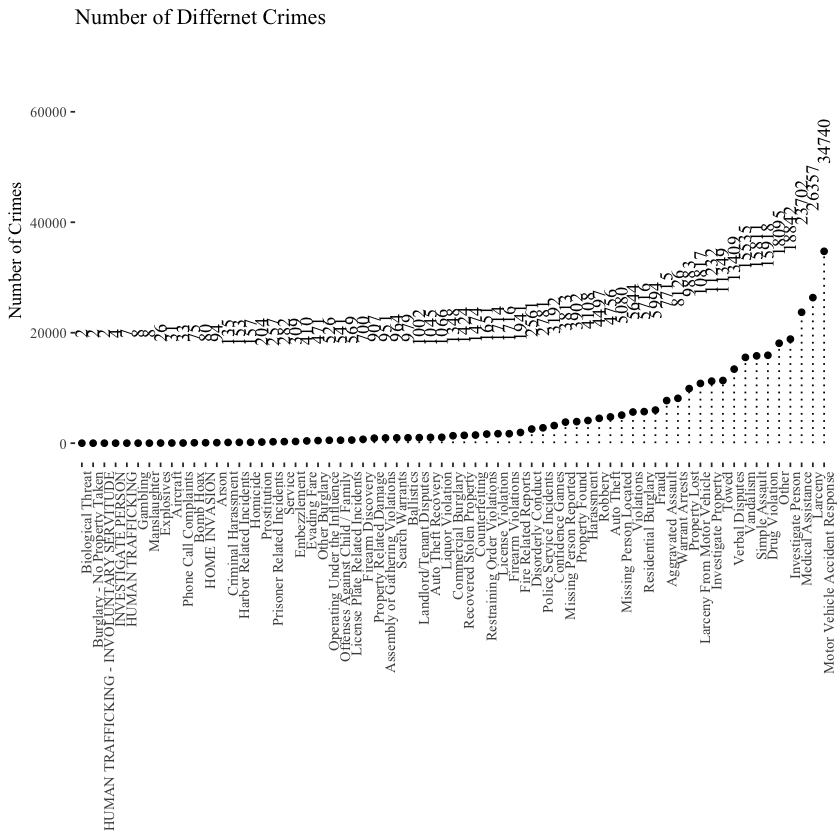

In [4]:
# summarise the number of different incidents
data %>%
  group_by(OFFENSE_CODE_GROUP) %>%
  summarise(number = n()) %>%
  # the forth most common meaningful crime is "Larceny", "Drug Violation", "Simple Assault" and "Vandalism"
  ggplot(aes(fct_reorder(OFFENSE_CODE_GROUP, number), number)) +
  geom_point() +
  geom_text(aes(fct_reorder(OFFENSE_CODE_GROUP, number), number + 20000, label = number), 
            angle = 90, family = "Times New Roman") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1), panel.background = element_blank(), 
        text = element_text(family = "Times New Roman")) + xlab(NULL) + 
  coord_cartesian(ylim = c(0, 70000)) + ylab("Number of Crimes") +
  ggtitle("Number of Differnet Crimes") +
  geom_segment(aes(x = OFFENSE_CODE_GROUP, y = 0, xend = OFFENSE_CODE_GROUP, yend = number), linetype = "dotted")

In [5]:
crime_location <- data %>%
  filter(OFFENSE_CODE_GROUP %in% c("Larceny", "Drug Violation", "Simple Assault", "Vandalism")) %>%
  group_by(STREET, OFFENSE_CODE_GROUP) %>%
  summarise(crime_number = n()) %>% # totally 7839 streets, too many
  filter(crime_number > 9) %>%
  arrange(desc(crime_number))

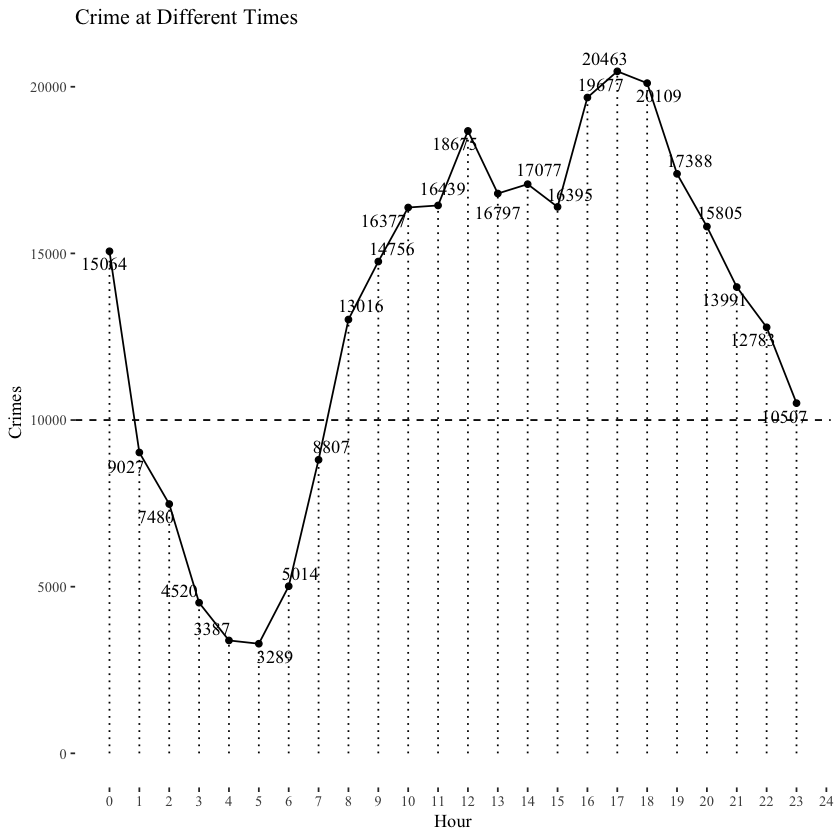

In [6]:
# visualize time pattern of incidents druing a day
data %>%
  group_by(HOUR) %>%
  summarise(crimes = n()) %>%
  ggplot(aes(HOUR, crimes)) +
  geom_line(group = 1) +
  geom_point(aes(HOUR, crimes)) +
  geom_text_repel(aes(HOUR, crimes, label = crimes), family = "Times New Roman") +
  theme(panel.background = element_blank(), text = element_text(family = "Times New Roman")) + 
  scale_x_continuous(breaks = seq(0, 24, 1)) +
  ggtitle("Crime at Different Times") + xlab("Hour") + ylab("Crimes") + 
  geom_hline(yintercept = 10000, linetype = 2) + 
  geom_segment(aes(x= HOUR, y = 0, xend = HOUR, yend = crimes), linetype = "dotted")

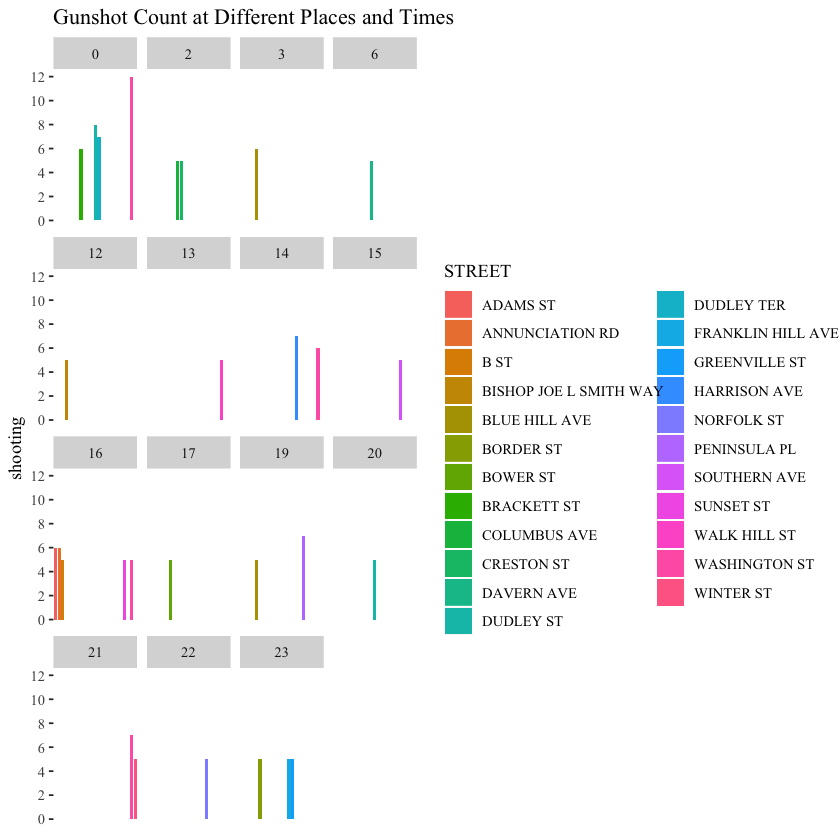

In [7]:
# summarise the time and places of shooting
data %>%
  filter(SHOOTING == 1) %>%
  group_by(STREET, HOUR) %>%
  summarise(shooting = n()) %>%
  arrange(desc(shooting)) %>%
  filter(shooting > 4) %>%
  ggplot(aes(STREET, shooting, fill = STREET)) +
  geom_col(position = "stack") +
  facet_wrap(~HOUR) +
  theme(panel.background = element_blank(), axis.title.x = element_blank(), axis.text.x = element_blank(), 
        axis.ticks.x = element_blank(), text = element_text(family = "Times New Roman")) +
  ggtitle("Gunshot Count at Different Places and Times") +
  scale_y_continuous(breaks = seq(0, 12, 2))

In [8]:
# extract geocode of palces of crimes
register_google(key = 'my_google_key_here') # use your key!

crime_location$STREET <- as.character(paste(crime_location$STREET, ", boston, ma", sep = ""))

geocode <- suppressMessages(geocode(crime_location$STREET))
street_geo <- bind_cols(crime_location, geocode)

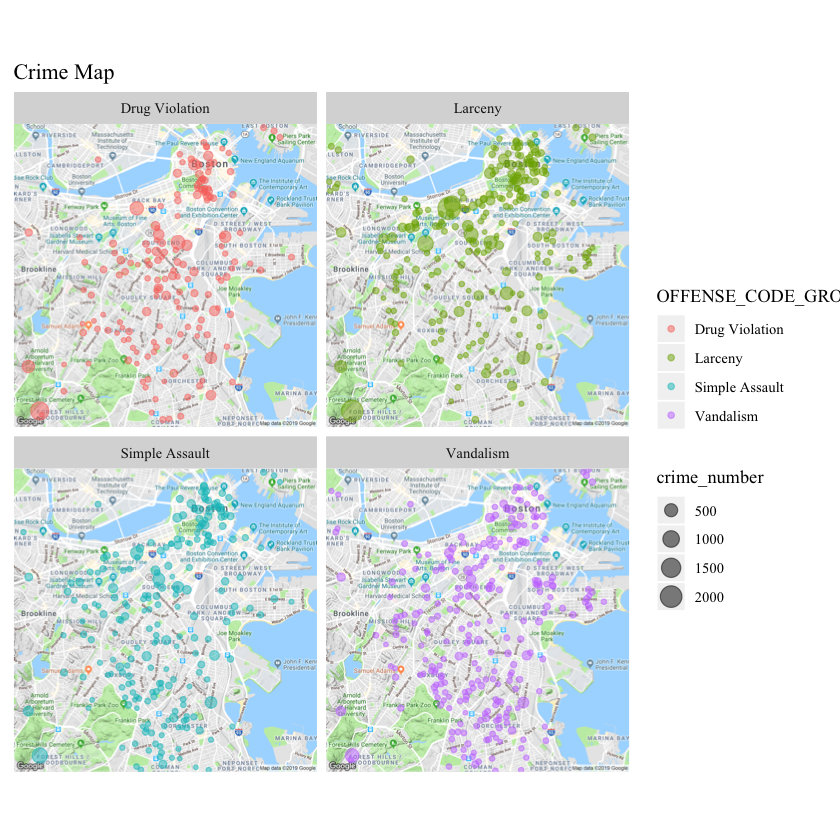

In [10]:
# visualize the crime map
suppressMessages(ggmap(get_map(location = c(-71.075, 42.33), zoom = 13)) +
  geom_jitter(data = street_geo, aes(x = lon, y = lat, size = crime_number, 
                                     color = OFFENSE_CODE_GROUP), alpha = 0.5) +
  facet_wrap(~ OFFENSE_CODE_GROUP) +
  ggtitle("Crime Map") +
  theme(text = element_text(family = "Times New Roman"), axis.text = element_blank(), 
        axis.ticks = element_blank()) + xlab(NULL) + ylab(NULL))